In [2]:
from util import get_normalized_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
def init_weight(M1, M2):
	return np.random.randn(M1, M2) * np.sqrt(2.0 / M1)


class HiddenLayerBatchNorm(object):
	def __init__(self, M1, M2, f):
		self.M1 = M1
		self.M2 = M2
		self.f = f

		W = init_weight(M1, M2).astype(np.float32)
		gamma = np.ones(M2).astype(np.float32)
		beta = np.zeros(M2).astype(np.float32)

		self.W = tf.Variable(W)
		self.gamma = tf.Variable(gamma)
		self.beta = tf.Variable(beta)

		# for test time
		self.running_mean = tf.Variable(np.zeros(M2).astype(np.float32), trainable=False)
		self.running_var = tf.Variable(np.zeros(M2).astype(np.float32), trainable=False)

	def forward(self, X, is_training, decay=0.9):
		activation = tf.matmul(X, self.W)
		if is_training:
			batch_mean, batch_var = tf.nn.moments(activation, [0])
			update_running_mean = tf.assign(
				self.running_mean,
				self.running_mean * decay + batch_mean * (1 - decay)
			)
			update_running_var = tf.assign(
				self.running_var,
				self.running_var * decay + batch_var * (1 - decay)
			)
			
			with tf.control_dependencies([update_running_mean, update_running_var]):
				out = tf.nn.batch_normalization(
					activation,
					batch_mean,
					batch_var,
					self.beta,
					self.gamma,
					1e-4
				)
		else:
			out = tf.nn.batch_normalization(
				activation,
				self.running_mean,
				self.running_var,
				self.beta,
				self.gamma,
				1e-4
			)
		return self.f(out)

In [5]:
class HiddenLayer(object):
	def __init__(self, M1, M2, f):
		self.M1 = M1
		self.M2 = M2
		self.f = f
		W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
		b = np.zeros(M2)
		self.W = tf.Variable(W.astype(np.float32))
		self.b = tf.Variable(b.astype(np.float32))

	def forward(self, X):
		return self.f(tf.matmul(X, self.W) + self.b)

In [6]:
class ANN(object):
	def __init__(self, hidden_layer_sizes):
		self.hidden_layer_sizes = hidden_layer_sizes

	def set_session(self, session):
		self.session = session

	def fit(self, X, Y, Xtest, Ytest, activation=tf.nn.relu, learning_rate=1e-2, epochs=15, batch_sz=100, print_period=100, show_fig=True):
		X = X.astype(np.float32)
		Y = Y.astype(np.int32)

		# initialize hidden layers
		N, D = X.shape
		self.layers = []
		M1 = D
		for M2 in self.hidden_layer_sizes:
			h = HiddenLayerBatchNorm(M1, M2, activation)
			self.layers.append(h)
			M1 = M2
			
		# final layer
		K = len(set(Y))
		h = HiddenLayer(M1, K, lambda x: x)
		self.layers.append(h)

		if batch_sz is None:
			batch_sz = N


		# note! we will need to build the output differently
		# for train and test (prediction)

		# set up theano functions and variables
		tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
		tfY = tf.placeholder(tf.int32, shape=(None,), name='Y')

		# for later use
		self.tfX = tfX

		# for training
		logits = self.forward(tfX, is_training=True)
		cost = tf.reduce_mean(
			tf.nn.sparse_softmax_cross_entropy_with_logits(
				logits=logits,
				labels=tfY
			)
		)
		# train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
		# train_op = tf.train.RMSPropOptimizer(learning_rate, decay=0.99, momentum=0.9).minimize(cost)
		train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(cost)
		# train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

		# for testing
		test_logits = self.forward(tfX, is_training=False)
		self.predict_op = tf.argmax(test_logits, 1)

		# accuracy = tf.reduce_mean(1.0*(tfY == tf.argmax(logits, 1)))

		# init the variables
		self.session.run(tf.global_variables_initializer())

		n_batches = N // batch_sz
		costs = []
		for i in range(epochs):
			if n_batches > 1:
				X, Y = shuffle(X, Y)
			for j in range(n_batches):
				Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
				Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

				c, _, lgts = self.session.run([cost, train_op, logits], feed_dict={tfX: Xbatch, tfY: Ybatch})
				costs.append(c)
				if (j+1) % print_period == 0:
					acc = np.mean(Ybatch == np.argmax(lgts, axis=1))
					print("epoch:", i, "batch:", j, "n_batches:", n_batches, "cost:", c, "acc: %.2f" % acc)
					# print('dbg:', self.session.run(self.layers[0].running_mean).sum())

			print("Train acc:", self.score(X, Y), "Test acc:", self.score(Xtest, Ytest))
		
		if show_fig:
			plt.plot(costs)
			plt.show()

	def forward(self, X, is_training):
		out = X
		for h in self.layers[:-1]:
			out = h.forward(out, is_training)
		out = self.layers[-1].forward(out)
		return out

	def score(self, X, Y):
		P = self.predict(X)
		return np.mean(Y == P)

	def predict(self, X):
		return self.session.run(self.predict_op, feed_dict={self.tfX: X})

Reading in and transforming data...
epoch: 0 batch: 99 n_batches: 410 cost: 0.515462 acc: 0.86
epoch: 0 batch: 199 n_batches: 410 cost: 0.245739 acc: 0.93
epoch: 0 batch: 299 n_batches: 410 cost: 0.221408 acc: 0.95
epoch: 0 batch: 399 n_batches: 410 cost: 0.144711 acc: 0.96
Train acc: 0.962268292683 Test acc: 0.946
epoch: 1 batch: 99 n_batches: 410 cost: 0.129652 acc: 0.97
epoch: 1 batch: 199 n_batches: 410 cost: 0.103494 acc: 0.97
epoch: 1 batch: 299 n_batches: 410 cost: 0.124998 acc: 0.98
epoch: 1 batch: 399 n_batches: 410 cost: 0.114213 acc: 0.99
Train acc: 0.979585365854 Test acc: 0.955
epoch: 2 batch: 99 n_batches: 410 cost: 0.0672628 acc: 0.99
epoch: 2 batch: 199 n_batches: 410 cost: 0.0502289 acc: 0.99
epoch: 2 batch: 299 n_batches: 410 cost: 0.110449 acc: 0.97
epoch: 2 batch: 399 n_batches: 410 cost: 0.082089 acc: 0.99
Train acc: 0.987 Test acc: 0.955
epoch: 3 batch: 99 n_batches: 410 cost: 0.0672467 acc: 0.97
epoch: 3 batch: 199 n_batches: 410 cost: 0.0535344 acc: 0.99
epoch: 

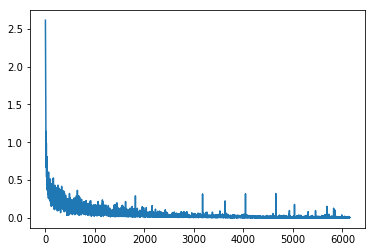

Train accuracy: 0.99987804878
Test accuracy: 0.968


In [7]:
# step 1: get the data and define all the usual variables
X, Y = get_normalized_data()
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.03)
X, Y = shuffle(X, Y)
Xtrain, Ytrain = X[:-1000], Y[:-1000]
Xtest, Ytest = X[-1000:], Y[-1000:]

ann = ANN([500, 300])

session = tf.InteractiveSession()
ann.set_session(session)

ann.fit(Xtrain, Ytrain, Xtest, Ytest, show_fig=True)

print("Train accuracy:", ann.score(Xtrain, Ytrain))
print("Test accuracy:", ann.score(Xtest, Ytest))